<a href="https://colab.research.google.com/github/Yvnminc/COMP5329_A2/blob/main/Experiment_yann_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Code to download file into Colaboratory:
# !pip install -U -q PyDrive > /dev/null
# !pip install torchmetrics > /dev/null
# from pydrive.auth import GoogleAuth
# import torch
# dev = "cuda" if torch.cuda.is_available() else "cpu"
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# #get the data from the drive
# def get_feature(model = "ViT-L/14@336px"):
#   id = '11yXddz5j-IDcH77wkMF7dW2JctRv7YN6'
#   size = "B"

#   if model == 'ViT-L/14@336px':
#     id = '1P6CgrgiIACjnhtHsUwdY8qjZ-E3Vx_0x'
#     size = "L336"
#   elif model == 'ViT-L/14':
#     id = '1DG4J-YF57ZsfXTzwg5EFfkzUmUFfr82h'
#     size = "L"
#   elif model == 'ViT-B/32':
#     id = '11yXddz5j-IDcH77wkMF7dW2JctRv7YN6'
#     size = "B"

#   downloaded = drive.CreateFile({'id':id}) 
#   downloaded.GetContentFile('clip_features.zip')

#   #get the data from the drive
#   id = '1b-ujWaLM_jOzlRMbXVb9T-3oEibKQW1r'
#   downloaded = drive.CreateFile({'id':id}) 
#   downloaded.GetContentFile('label_onehot_tensor.pt')

#   !unzip clip_features.zip > /dev/null

#   test_image_features = torch.load(f"test_image_features_vit{size}.pt")
#   test_text_feature = torch.load(f"test_text_feature_vit{size}.pt")
#   all_image_features = torch.load(f"all_image_features_vit{size}.pt")
#   all_text_feature = torch.load(f"all_text_feature_vit{size}.pt")
#   label_onehot_tensor = torch.load(f"label_onehot_tensor.pt")

#   return all_image_features, all_text_feature, test_image_features, test_text_feature, label_onehot_tensor

In [2]:
# all_image_features, all_text_feature, test_image_features, test_text_feature, label_onehot_tensor = get_feature()

In [3]:
# import torch
# dev = "cuda" if torch.cuda.is_available() else "cpu"
# test_image_features = torch.load("test_image_features_vitL.pt", map_location = torch.device(dev))
# test_text_feature = torch.load("test_text_feature_vitL.pt", map_location = torch.device(dev))
# all_image_features = torch.load("all_image_features_vitL.pt", map_location = torch.device(dev))
# all_text_feature = torch.load("all_text_feature_vitL.pt", map_location = torch.device(dev))
# label_onehot_tensor = torch.load("label_onehot_tensor.pt", map_location = torch.device(dev))

In [4]:
import torch
dev = "cuda" if torch.cuda.is_available() else "cpu"
test_image_features = torch.load("features/test_image_features_vitL.pt", map_location = torch.device(dev))
test_text_feature = torch.load("features/test_text_feature_vitL.pt", map_location = torch.device(dev))
all_image_features = torch.load("features/all_image_features_vitL.pt", map_location = torch.device(dev))
all_text_feature = torch.load("features/all_text_feature_vitL.pt", map_location = torch.device(dev))
label_onehot_tensor = torch.load("features/label_onehot_tensor.pt", map_location = torch.device(dev))

In [5]:
test_image_features.shape

torch.Size([10000, 768])

In [6]:
def add_weight_decay(model, weight_decay=1e-4, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [7]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        
        xs_pos = x
        xs_neg = 1 - x

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))
        
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

In [8]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import F1Score
from torch import optim
from torch.cuda.amp import GradScaler, autocast

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
def Trainer(model, Data, epochs, epoch_step_1, epoch_step_2, lr = 1e-3):
    torch.manual_seed(5329)
    train_data = DataLoader(TensorDataset(Data[:25000], label_onehot_tensor[:25000]), batch_size=25000, shuffle = True)
    val_data = DataLoader(TensorDataset(Data[25000:], label_onehot_tensor[25000:].to(torch.int32)), batch_size=5000, shuffle = False)
    
    # Change here to switch to the best setting
    # train_data = DataLoader(TensorDataset(Data, label_onehot_tensor), batch_size=30000, shuffle = True)
    
    model = model.to(dev)
 
    weight_decay = 2e-4
    criterion = AsymmetricLoss(gamma_neg=0, gamma_pos=0, clip=0, disable_torch_grad_focal_loss=True)
    parameters = add_weight_decay(model, weight_decay)
    opti = optim.Adam(params=parameters, lr=lr, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epochs
    train_loss = []
    val_loss = []
    f1_list = []
    scaler = GradScaler()
    
    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        for data, label in train_data:   
            data, label = data.to(dev), label.to(dev)

            with autocast():  # mixed precision
                output = model(data).float() 

            loss = criterion(output, label)
            model.zero_grad()
            
            scaler.scale(loss).backward()
            scaler.step(opti)
            scaler.update()
            
        train_loss.append(loss.item())
        
        with torch.autograd.no_grad():
            for data_val, label_val in val_data:
                data_val, label_val = data_val.to(dev), label_val.to(dev)
                predict = model(data_val)
                f1_score = f1(predict, label_val)
                v_loss = criterion(predict, label_val)
            val_loss.append(v_loss.item())
            f1_list.append(f1_score.item())
        
        # Comment the code below if you want to switch to the best settings (i.e., no validation data)
        if epoch % 10 == 0:
            print('Validation F1 in epoch{} : {:.4f}'.format(epoch, f1_score.item()))
            print('Validation loss in epoch{} : {:.4f}'.format(epoch, v_loss.item()))
    
    return model, train_loss, val_loss, f1_list

In [9]:
import torch.nn as nn
import torch.nn.functional as F


class SpatialGatingUnit(nn.Module):
    def __init__(self, d_ffn):
        super().__init__()
        self.layer_norm = nn.LayerNorm(d_ffn)
        self.fc = nn.Linear(d_ffn, d_ffn)
        
    def forward(self, x):
        u = self.layer_norm(x)
        g = torch.sigmoid(self.fc(u))
        return x * g

class gMLPBlock(nn.Module):
    def __init__(self, d_model, d_ffn):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ffn)
        self.bn1 = nn.BatchNorm1d(d_ffn)
        self.sgu = SpatialGatingUnit(d_ffn)
        self.fc2 = nn.Linear(d_ffn, d_model)
        self.dropout = nn.Dropout(p = 0.5)

        # He initialization
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')

    def forward(self, x):
        residual = x
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.bn1(x)
        x = F.gelu(x)
        x = self.sgu(x)
        x = self.fc2(x)
        return x + residual

class Feature(nn.Module):
    def __init__(self, gblock_bool = False):
        super().__init__()
        self.gblock_bool = gblock_bool
        self.gblock1 = gMLPBlock(768, 768)
        self.gblock2 = gMLPBlock(768, 768)
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 18)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, inputs):
        if self.gblock_bool:
            inputs = self.gblock1(inputs)
            #inputs = self.gblock2(inputs)

        inputs = F.gelu(self.fc1(inputs))
        inputs = self.dropout(inputs)
        inputs = torch.sigmoid(self.fc2(inputs))
        return inputs

class Decision(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

In [10]:
class gMLP_feature(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = gMLPBlock(768, 768)
        self.block2 = gMLPBlock(768, 768)
        self.fc = nn.Linear(768, 18)

    def forward(self, inputs):
        tensor = self.block1(inputs)
        tensor = self.block2(tensor)
        tensor = torch.sigmoid(self.fc(tensor))
        return tensor

class gMLP_decision(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = gMLPBlock(18, 18)
        self.block2 = gMLPBlock(18, 18)
        self.fc = nn.Linear(18, 18)

    def forward(self, inputs):
        tensor = self.block1(inputs)
        tensor = self.block2(tensor)
        tensor = torch.sigmoid(self.fc(tensor))
        return tensor

## Case 1: Use only Image Features

In [11]:
import os
Net, train_image_loss, val_image_loss, f1_image_list = Trainer(Feature(), all_image_features, 200, 100, 150)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))

  0%|▍                                                                                 | 1/200 [00:00<03:11,  1.04it/s]

Validation F1 in epoch0 : 0.1648
Validation loss in epoch0 : 61593.6016


  6%|████▍                                                                            | 11/200 [00:03<00:50,  3.75it/s]

Validation F1 in epoch10 : 0.1631
Validation loss in epoch10 : 61602.1875


 10%|████████▌                                                                        | 21/200 [00:06<00:48,  3.67it/s]

Validation F1 in epoch20 : 0.6032
Validation loss in epoch20 : 18728.2500


 16%|████████████▌                                                                    | 31/200 [00:09<00:47,  3.54it/s]

Validation F1 in epoch30 : 0.7262
Validation loss in epoch30 : 11977.9121


 20%|████████████████▌                                                                | 41/200 [00:12<00:44,  3.56it/s]

Validation F1 in epoch40 : 0.7765
Validation loss in epoch40 : 8983.5352


 26%|████████████████████▋                                                            | 51/200 [00:15<00:42,  3.51it/s]

Validation F1 in epoch50 : 0.8159
Validation loss in epoch50 : 7720.6489


 30%|████████████████████████▋                                                        | 61/200 [00:18<00:46,  2.97it/s]

Validation F1 in epoch60 : 0.8295
Validation loss in epoch60 : 7174.9043


 36%|████████████████████████████▊                                                    | 71/200 [00:21<00:36,  3.54it/s]

Validation F1 in epoch70 : 0.8392
Validation loss in epoch70 : 6840.6631


 40%|████████████████████████████████▊                                                | 81/200 [00:24<00:33,  3.51it/s]

Validation F1 in epoch80 : 0.8424
Validation loss in epoch80 : 6727.0674


 46%|████████████████████████████████████▊                                            | 91/200 [00:27<00:30,  3.62it/s]

Validation F1 in epoch90 : 0.8439
Validation loss in epoch90 : 6627.5703


 50%|████████████████████████████████████████▍                                       | 101/200 [00:30<00:27,  3.56it/s]

Validation F1 in epoch100 : 0.8460
Validation loss in epoch100 : 6544.0566


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:33<00:26,  3.31it/s]

Validation F1 in epoch110 : 0.8475
Validation loss in epoch110 : 6500.1201


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:35<00:23,  3.40it/s]

Validation F1 in epoch120 : 0.8490
Validation loss in epoch120 : 6451.8198


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:38<00:19,  3.48it/s]

Validation F1 in epoch130 : 0.8500
Validation loss in epoch130 : 6429.8315


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:41<00:16,  3.67it/s]

Validation F1 in epoch140 : 0.8519
Validation loss in epoch140 : 6374.5894


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:44<00:14,  3.31it/s]

Validation F1 in epoch150 : 0.8514
Validation loss in epoch150 : 6398.9111


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:47<00:10,  3.58it/s]

Validation F1 in epoch160 : 0.8525
Validation loss in epoch160 : 6338.3447


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:50<00:09,  3.16it/s]

Validation F1 in epoch170 : 0.8529
Validation loss in epoch170 : 6346.1064


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:53<00:05,  3.22it/s]

Validation F1 in epoch180 : 0.8537
Validation loss in epoch180 : 6368.2051


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [00:56<00:02,  3.46it/s]

Validation F1 in epoch190 : 0.8553
Validation loss in epoch190 : 6344.4004


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:59<00:00,  3.37it/s]


In [12]:
import os
Net, g_train_image_loss, g_val_image_loss, g_f1_image_list = Trainer(gMLP_feature(), all_image_features,  200, 100, 150)
Net.eval()
with torch.autograd.no_grad():
    img_train = Net(all_image_features.to(dev))
    img_test = Net(test_image_features.to(dev))

  0%|▍                                                                                 | 1/200 [00:00<01:09,  2.86it/s]

Validation F1 in epoch0 : 0.1094
Validation loss in epoch0 : 68824.4062


  6%|████▍                                                                            | 11/200 [00:03<00:57,  3.29it/s]

Validation F1 in epoch10 : 0.1096
Validation loss in epoch10 : 68857.9297


 10%|████████▌                                                                        | 21/200 [00:06<00:55,  3.20it/s]

Validation F1 in epoch20 : 0.5953
Validation loss in epoch20 : 15601.7090


 16%|████████████▌                                                                    | 31/200 [00:09<00:52,  3.23it/s]

Validation F1 in epoch30 : 0.6437
Validation loss in epoch30 : 13118.0537


 20%|████████████████▌                                                                | 41/200 [00:12<00:49,  3.19it/s]

Validation F1 in epoch40 : 0.7745
Validation loss in epoch40 : 9467.9541


 26%|████████████████████▋                                                            | 51/200 [00:16<00:47,  3.16it/s]

Validation F1 in epoch50 : 0.8146
Validation loss in epoch50 : 7772.9141


 30%|████████████████████████▋                                                        | 61/200 [00:19<00:45,  3.06it/s]

Validation F1 in epoch60 : 0.8316
Validation loss in epoch60 : 7085.8394


 36%|████████████████████████████▊                                                    | 71/200 [00:22<00:41,  3.13it/s]

Validation F1 in epoch70 : 0.8373
Validation loss in epoch70 : 6868.7432


 40%|████████████████████████████████▊                                                | 81/200 [00:25<00:36,  3.24it/s]

Validation F1 in epoch80 : 0.8405
Validation loss in epoch80 : 6701.0928


 46%|████████████████████████████████████▊                                            | 91/200 [00:28<00:33,  3.24it/s]

Validation F1 in epoch90 : 0.8479
Validation loss in epoch90 : 6580.7607


 50%|████████████████████████████████████████▍                                       | 101/200 [00:31<00:31,  3.19it/s]

Validation F1 in epoch100 : 0.8479
Validation loss in epoch100 : 6598.9258


 56%|████████████████████████████████████████████▍                                   | 111/200 [00:35<00:28,  3.10it/s]

Validation F1 in epoch110 : 0.8471
Validation loss in epoch110 : 6706.0889


 60%|████████████████████████████████████████████████▍                               | 121/200 [00:38<00:25,  3.11it/s]

Validation F1 in epoch120 : 0.8499
Validation loss in epoch120 : 6842.4126


 66%|████████████████████████████████████████████████████▍                           | 131/200 [00:41<00:22,  3.07it/s]

Validation F1 in epoch130 : 0.8453
Validation loss in epoch130 : 7080.1089


 70%|████████████████████████████████████████████████████████▍                       | 141/200 [00:44<00:19,  3.10it/s]

Validation F1 in epoch140 : 0.8438
Validation loss in epoch140 : 7555.4927


 76%|████████████████████████████████████████████████████████████▍                   | 151/200 [00:47<00:15,  3.20it/s]

Validation F1 in epoch150 : 0.8411
Validation loss in epoch150 : 8080.2549


 80%|████████████████████████████████████████████████████████████████▍               | 161/200 [00:51<00:12,  3.14it/s]

Validation F1 in epoch160 : 0.8410
Validation loss in epoch160 : 8479.0439


 86%|████████████████████████████████████████████████████████████████████▍           | 171/200 [00:54<00:09,  3.19it/s]

Validation F1 in epoch170 : 0.8364
Validation loss in epoch170 : 9208.4951


 90%|████████████████████████████████████████████████████████████████████████▍       | 181/200 [00:57<00:05,  3.17it/s]

Validation F1 in epoch180 : 0.8371
Validation loss in epoch180 : 9881.4375


 96%|████████████████████████████████████████████████████████████████████████████▍   | 191/200 [01:00<00:02,  3.15it/s]

Validation F1 in epoch190 : 0.8358
Validation loss in epoch190 : 10334.8652


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [01:03<00:00,  3.16it/s]


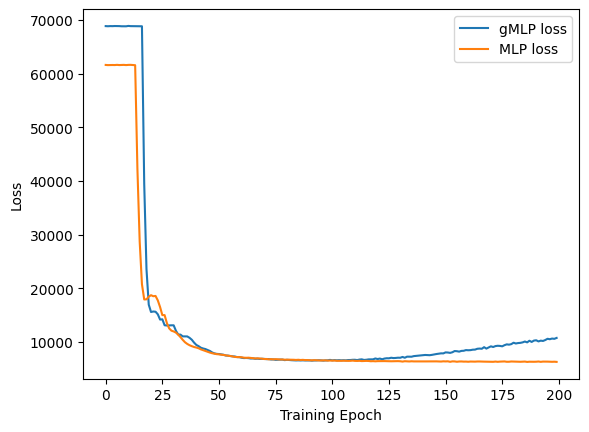

In [13]:
import matplotlib.pyplot as plt
plt.plot(g_val_image_loss, label='gMLP loss')
plt.plot(val_image_loss, label='MLP loss')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('mlploss.png')
plt.show()

In [14]:
print(f1_image_list[-1])
print(g_f1_image_list[-1])

0.8556700944900513
0.8350638747215271


In [16]:
import numpy as np

MLP = [0.8561336994171143, 0.8542091846466064, 0.8556700944900513]
GMLP = [0.8350638747215271, 0.8350638747215271, 0.8350638747215271]

print("Mean: ", np.mean(MLP), np.mean(GMLP))
print('Std: ', np.std(MLP), np.std(GMLP))

Mean:  0.855337659517924 0.8350638747215271
Std:  0.0008200910654700217 0.0
